In [1]:
import numpy as np
import pandas as pd
import cooler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
from numpy.random import uniform

In [2]:
ep_long = pd.read_csv('/data2/josh/ep/activePairixAll.csv')

In [3]:
# Import and define chromosomes df - mm10
c = cooler.Cooler('/data2/josh/stan/merge_res200.cool')
chrs = c.chroms()[:]
chrs['name'] = chrs['name'].str.replace('chr', '')
chrs = chrs.set_index('name')
chrs.index.names = ['chrom']

In [4]:
# Import TAD list
tads = pd.read_csv('/data2/josh/tads/TAD_mm10.csv', delimiter='\t')
tads['chrom'] = tads['chrom'].str.replace('chr','')
tads['size'] = tads['end'] - tads['start']
chr_coverage = tads.groupby('chrom').sum()['size'].to_frame()
chr_coverage = chr_coverage.join(chrs)
chr_coverage['ratio'] = chr_coverage['size']/chr_coverage['length']
# chr_coverage.sort_values('ratio')

In [5]:
# define helper function ep_status
def ep_status(e_chip, p_chip):
    if ((e_chip == True) and (p_chip == True)):
        return 'EP'
    elif ((e_chip == False) and (p_chip == True)):
        return 'P'
    elif ((e_chip == True) and (p_chip == False)):
        return 'E'
    else:
        return 'N'

In [17]:
chipfiles = ['H3K27ac','H3K36me3','H3K4me1',
             'H3K4me3','H3K9ac',
             'c-Myc','CTCF','Esrrb','Klf4','Nanog','Oct4','Sox2','Suz12']

0.0
0.0
Finished H3K27ac
0.0
0.0
Finished H3K36me3
0.0
0.0


KeyError: 'P'

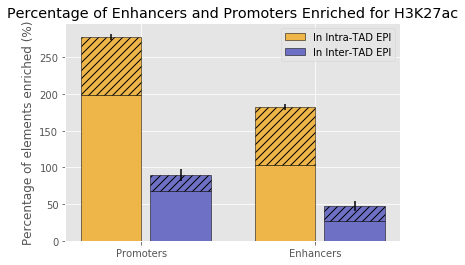

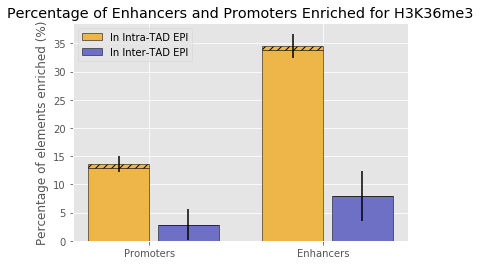

In [24]:
for chipname in chipfiles:
    # ChIP-seq to plot
    chipname_lower = chipname.lower()
    chipfile = '/data2/josh/chipseq/' + chipname + '/' + chipname_lower + '_mm10.bed'

    # Add chromatin labels
    chip = pd.read_csv(chipfile, delimiter='\t', header=None)
    chip.columns = ['chr', 'start', 'end', 'id', 'strength']

    # Label promoters as ChIP-seq overlapping or not (new column)
    promoters_chip_list = []
    counter = 0
    for idx, row in ep_long.iterrows():
        chrom = row.p_chr
        p_start = row.p_start
        p_end = row.p_end
        chip_matches = chip[(chip['chr'] == chrom) & ((chip['start'] < p_start) & (chip['end'] > p_start) |
                                                      (chip['start'] < p_end) & (chip['end'] > p_end))]
        if chip_matches.empty:
            promoters_chip_list.append(False)
        else:
            promoters_chip_list.append(True)
        if counter % 1000 == 0:
            print(float(counter)/39277)
        counter += 1

    ep_long['p_chip'] = ''
    ep_long['p_chip'] = promoters_chip_list
    
    # Label enhancers as ChIP-seq overlapping or not (new column)
    enhancers_chip_list = []
    counter = 0
    for idx, row in ep_long.iterrows():
        chrom = row.e_chr
        e_start = row.e_start
        e_end = row.e_end

        chip_matches = chip[(chip['chr'] == chrom) & ((chip['start'] < e_start) & (chip['end'] > e_start) |
                                                      (chip['start'] < e_end) & (chip['end'] > e_end))]
        if chip_matches.empty:
            enhancers_chip_list.append(False)
        else:
            enhancers_chip_list.append(True)
        if counter % 1000 == 0:
            print(float(counter)/39277)
        counter += 1

    ep_long['e_chip'] = ''
    ep_long['e_chip'] = enhancers_chip_list
    
    # Add TAD label for promoters
    promoters_tad_list = []
    for idx, row in ep_long.iterrows():
        chrom = row.p_chr[3:]
        pos = row.p_center
        tad_matches = tads[(tads['chrom'] == chrom) & (tads['start'] < pos) & (tads['end'] > pos)]
        if tad_matches.empty:
            promoters_tad_list.append(-1)
        else:
            promoters_tad_list.append(tad_matches.index[0])

    ep_long['p_tad'] = ''
    ep_long['p_tad'] = promoters_tad_list
    
    # Label EPIs as Inter or Intra
    # pix1_tad_list1 = [None] * pix1.shape[0]
    ep_long['tad_status'] = ''
    tad_list = []
    counter = 0

    for idx, row in ep_long.iterrows():
        p_chr = row['p_chr'][3:]
        e_chr = row['e_chr'][3:]
        p_start = row['p_start']
        p_end = row['p_end']
        e_start = row['e_start']
        e_end = row['e_end']

        p_tad_matches = tads[((tads['chrom'] == p_chr) & (tads['start'] < p_start) & (tads['end'] > p_end))]
        e_tad_matches = tads[((tads['chrom'] == e_chr) &(tads['start'] < e_start) & (tads['end'] > e_end))]
        if p_tad_matches.empty and e_tad_matches.empty:
            tad_list.append('TAD-less')
        elif (p_tad_matches.empty and not e_tad_matches.empty) or (e_tad_matches.empty and not p_tad_matches.empty):
            tad_list.append('Inter')
        elif p_tad_matches.index[0] == e_tad_matches.index[0]:
            tad_list.append('Intra')
        else:
            tad_list.append('Inter')

        #if counter % 1000 == 0:
        #    print(float(counter)/39277)
        #counter += 1

    ep_long['tad_status'] = tad_list
    
    # Create list for EP_status the put it into the df 
    ep_status_list = [ep_status(row['e_chip'], row['p_chip']) for idx, row in ep_long.iterrows()]
    ep_long['ep_status'] = ep_status_list
    
    intra_ep = ep_long[ep_long['tad_status']=='Intra']
    inter_ep = ep_long[ep_long['tad_status']=='Inter']
    
    # Calculate frequencies for each group
    ep = ep_long
    
    contacts_tot = len(ep['ep_status'])
    E_tot = ep['ep_status'].value_counts()['E']
    P_tot = ep['ep_status'].value_counts()['P']
    N_tot = ep['ep_status'].value_counts()['N']
    EP_tot = ep['ep_status'].value_counts()['EP']
    
    prob_E = float(E_tot + EP_tot)/contacts_tot
    prob_P = float(P_tot + EP_tot)/contacts_tot
    prob_N = float(N_tot)/contacts_tot
    
    if EP_tot > 0:
        prob_EP = float(EP_tot)/contacts_tot
    else:
        prob_EP = 0

    intra_tot = len(inter_ep['ep_status'])
    E_intra_tot = intra_ep['ep_status'].value_counts()['E']
    P_intra_tot = intra_ep['ep_status'].value_counts()['P']
    N_intra_tot = intra_ep['ep_status'].value_counts()['N']
    EP_intra_tot = intra_ep['ep_status'].value_counts()['EP']
    
    if EP_intra_tot > 0:
        prob_EP_intra = float(EP_intra_tot)/contacts_tot
    else:
        prob_EP_intra = 0
    
    prob_E_intra = float(E_intra_tot + EP_intra_tot)/intra_tot
    prob_P_intra = float(P_intra_tot + EP_intra_tot)/intra_tot
    prob_N_intra = float(N_intra_tot)/intra_tot
    # prob_EP_intra = float(EP_tot)/len(intra_ep['ep_status'])
        
    if EP_intra_tot > 0:
        prob_EP_intra = float(EP_intra_tot)/intra_tot
    else:
        prob_EP_intra = 0

    inter_tot = len(inter_ep['ep_status'])
    E_inter_tot = inter_ep['ep_status'].value_counts()['E']
    P_inter_tot = inter_ep['ep_status'].value_counts()['P']
    N_inter_tot = inter_ep['ep_status'].value_counts()['N']
    if 'EP' in inter_ep['ep_status'].value_counts():
        EP_inter_tot = inter_ep['ep_status'].value_counts()['EP']
    else:
        EP_inter_tot = 0
    
    prob_E_inter = float(E_inter_tot + EP_inter_tot)/inter_tot
    prob_P_inter = float(P_inter_tot + EP_inter_tot)/inter_tot
    prob_N_inter = float(N_inter_tot)/inter_tot
    # prob_EP_inter = float(EP_inter_tot)/inter_tot
    
    if EP_inter_tot > 0:
        prob_EP_inter = float(EP_inter_tot)/inter_tot
    else:
        prob_EP_inter = 0

    # Generate intra error bars
    plot_ci_intra = []
    for prob in [prob_P, prob_E]:
        randoms_per_sim = len(intra_ep['ep_status'])
        num_sims = 1000 # does not affect value

        random_nums = uniform(0,1,(randoms_per_sim,num_sims))
        sims = sum(random_nums < prob)/float(randoms_per_sim) # Have 1000 statistics (converting numbers into %'s')
        # stdev of SIMS is stdev to use for plots -- stdev of null hypothesis
        # print(sims)
        # print('mean: ' + str(np.mean(sims)))
        stdev = np.std(sims)

        # print('stdev: ' + str(stdev))

        plot_ci_intra.append(1.96*stdev)

        # calculating p-vaue
        # pval = float(sum(prob_E_intra < sims))/num_sims
        # if (pval < 0.05) or (pval > 0.95):
        #     print('P-value = ' + str(pval) + ': significant!!!!')
        
    # Generate inter error bars
    plot_ci_inter = []
    for prob in [prob_P, prob_E]:
        randoms_per_sim = len(inter_ep['ep_status'])
        num_sims = 100000 # does not affect stdev

        random_nums = uniform(0,1,(randoms_per_sim,num_sims))
        sims = sum(random_nums < prob)/float(randoms_per_sim) # Have 1000 statistics (converting numbers into %'s')
        # stdev of SIMS is stdev to use for plots -- stdev of null hypothesis
        # print(sims)
        # print('mean: ' + str(np.mean(sims)))
        stdev = np.std(sims)

        # print('stdev: ' + str(stdev))

        plot_ci_inter.append(1.96*stdev)

        # calculating p-vaue
        # pval = float(sum(prob_P_inter < sims))/num_sims
        # if (pval < 0.05) or (pval > 0.95):
        #     print('P-value = ' + str(pval) + ': significant!!!!')
    
    intra_means = (prob_P_intra*100, prob_E_intra*100)
    intra_std = (plot_ci_intra[0]*100, plot_ci_intra[1]*100)

    inter_means = (prob_P_inter*100, prob_E_inter*100)
    inter_std = (plot_ci_inter[0]*100, plot_ci_inter[1]*100)

    intra_EP_means = (prob_EP_intra*100, prob_EP_intra*100)
    inter_EP_means = (prob_EP_inter*100, prob_EP_inter*100)

    fig, ax = plt.subplots()

    ind = np.arange(2)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, intra_means, width, color='#eeb549', bottom=0, edgecolor='black',)
    p3 = ax.bar(ind, intra_EP_means, width, color='#eeb549', bottom=intra_means, yerr=intra_std, hatch="///", edgecolor='black')

    p2 = ax.bar(ind + width+0.05, inter_means, width,  color='#6e70c5', bottom=0, edgecolor='black',)
    p4 = ax.bar(ind+width+0.05, inter_EP_means, width, color='#6e70c5', bottom=inter_means, yerr=inter_std, hatch="///", edgecolor='black')

    plt.ylabel('Percentage of elements enriched (%)') #, fontsize=24)

    ax.set_title('Percentage of Enhancers and Promoters Enriched for ' + chipname) #, fontsize=26)

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('Promoters', 'Enhancers')) #, fontsize=24)

    ax.legend((p1[0], p2[0]), ('In Intra-TAD EPI', 'In Inter-TAD EPI')) #, fontsize=20)

    # Save figure
    plt.savefig('figs/' + chipname + '_sbs_new.png')
    
    # Save data
    ep_long.to_csv('../results/processed_' + chipname_lower + '.bed',sep='\t')
    print('Finished ' + chipname)

In [22]:
inter_ep['ep_status'].value_counts()

N    124
E     11
P      4
Name: ep_status, dtype: int64